# Environment Preparation

In [1]:
!nvidia-smi

Thu Nov 13 07:10:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# HOME = '/workspace'
HOME = '/kaggle/working'

%cd {HOME}

/kaggle/working


In [28]:
from IPython.display import clear_output
from IPython.display import display, Image
from IPython.display import Image
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import numpy as np


In [4]:
!pip install ultralytics
clear_output()

from ultralytics import YOLO
!yolo checks

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6567.1/8062.4 GB disk)

OS                     Linux-6.6.56+-x86_64-with-glibc2.35
Environment            Colab
Python                 3.11.13
Install                pip
Path                   /usr/local/lib/python3.11/dist-packages/ultralytics
RAM                    31.35 GB
Disk                   6567.1/8062.4 GB
CPU                    Intel Xeon CPU @ 2.00GHz
CPU count              4
GPU                    Tesla P100-PCIE-16GB, 16269MiB
GPU count              1
CUDA                   12.4

numpy                  ✅ 2.2.6>=1.23.0
matplotlib        

In [32]:
# YOlO modelling only support numpy version 1.x
%pip uninstall numpy -y
%pip install "numpy<2.0"

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0

In [17]:
!pip install gdown
!gdown "https://drive.google.com/uc?export=download&id=1BIkQhW1Ws7pYFDikTjzHZsk1tKTb7gWL" -O ffb-dataset.zip
!mkdir -p ffb
!unzip ffb-dataset.zip -d ffb
!rm ffb-dataset.zip

clear_output()
print("Dataset telah terdownload.")

Dataset telah terdownload.


# Data Understanding

In [19]:
dataset = f'{HOME}/ffb'

!echo "Number of images in train:"
!ls -1 {dataset}/train/images | wc -l

!echo -e "\nNumber of images in validation:"
!ls -1 {dataset}/valid/images | wc -l

!echo -e "\nNumber of images in test:"
!ls -1 {dataset}/test/images | wc -l

Number of images in train:
202

Number of images in validation:
57

Number of images in test:
28


In [21]:
train_count = 202
validation_count = 57
test_count = 28

total_count = train_count + validation_count + test_count

train_percentage = (train_count / total_count) * 100
validation_percentage = (validation_count / total_count) * 100
test_percentage = (test_count / total_count) * 100

print(f"Train split: {train_percentage:.2f}%")
print(f"Validation split: {validation_percentage:.2f}%")
print(f"Test split: {test_percentage:.2f}%")

Train split: 70.38%
Validation split: 19.86%
Test split: 9.76%


In [22]:
train_images_path = os.path.join(dataset, 'train/images/')

first_image_name = os.listdir(train_images_path)[0]
first_image_path = os.path.join(train_images_path, first_image_name)

with Image.open(first_image_path) as img:
    width, height = img.size
    print(f"The first image '{first_image_name}' has dimensions: {width}x{height} pixels")

The first image 'DJI_20250530114448_0993_D_MP4-0003_jpg.rf.6a065d16bf1bb0e4d8afa9a4d657b30a.jpg' has dimensions: 1920x1080 pixels


Dataset has 4 classes: ['Buah belum matang', 'Buah busuk', 'Buah matang', 'Buah mau matang']

Displaying one unique image for each of the 4 found classes...


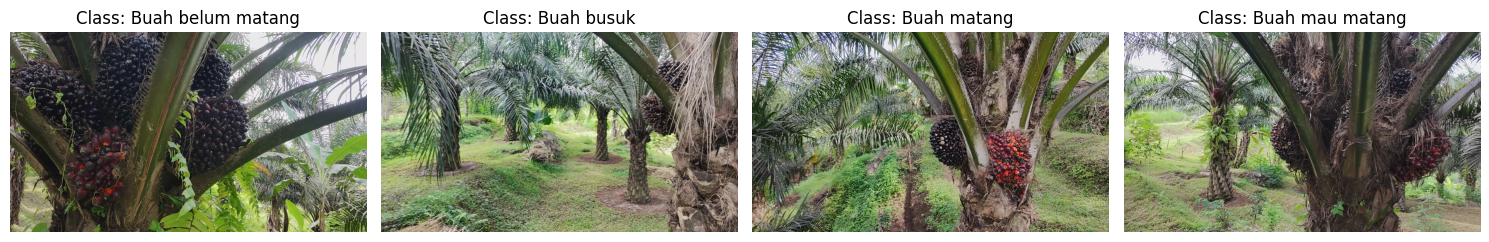

In [27]:
import os
import yaml
import random
import matplotlib.pyplot as plt
from PIL import Image

with open(os.path.join(dataset, 'data.yaml'), 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']
num_classes = data_yaml['nc']
print(f"Dataset has {num_classes} classes: {class_names}")

# Find a UNIQUE image for each class
class_image_map = {}
used_images = set()

labels_path = os.path.join(dataset, 'train/labels/')
label_files = os.listdir(labels_path)
random.shuffle(label_files)

for label_file in label_files:
    if len(class_image_map) == num_classes:
        break

    image_name = label_file.replace('.txt', '.jpg')

    if image_name in used_images:
        continue

    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])

            if class_id not in class_image_map:
                class_image_map[class_id] = image_name
                used_images.add(image_name)
                break

if not class_image_map:
    print("\nCould not find any labeled images to display.")
else:
    print(f"\nDisplaying one unique image for each of the {len(class_image_map)} found classes...")

    fig, axs = plt.subplots(1, len(class_image_map), figsize=(15, 5))

    if len(class_image_map) == 1:
        axs = [axs]

    for i, (class_id, image_name) in enumerate(sorted(class_image_map.items())):
        image_path = os.path.join(dataset, 'train/images/', image_name)
        try:
            image = Image.open(image_path)
            ax = axs[i]
            ax.imshow(image)
            ax.set_title(f"Class: {class_names[class_id]}")
            ax.axis('off')
        except FileNotFoundError:
            print(f"Warning: Could not find image '{image_name}' for class '{class_names[class_id]}'")

    plt.tight_layout()
    plt.show()

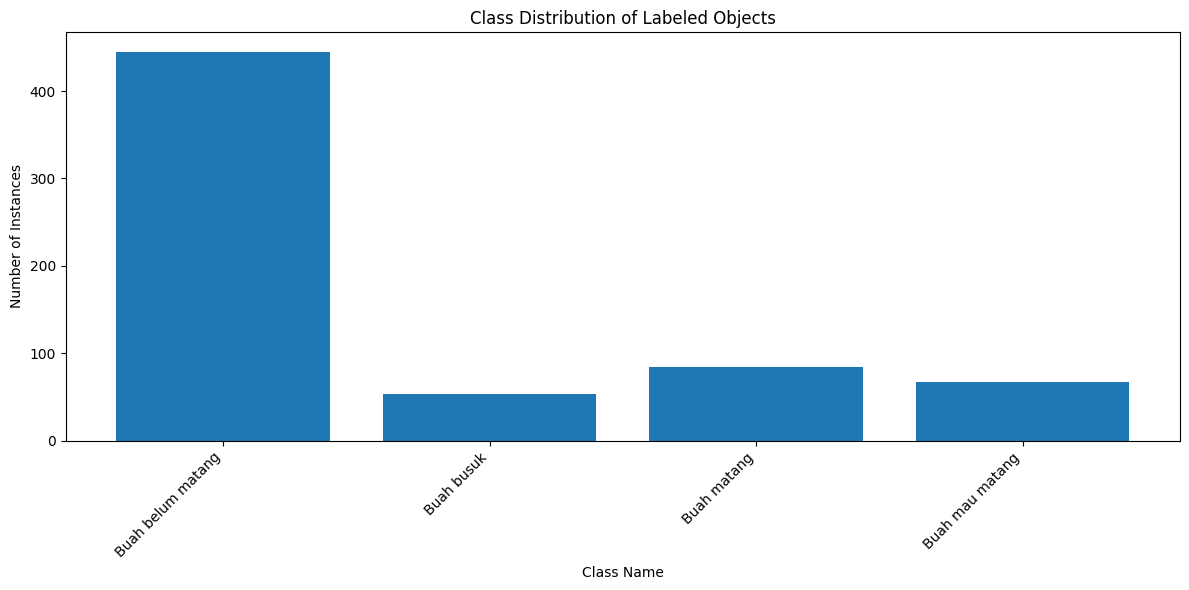

Instance counts per class:
- Buah belum matang: 445
- Buah busuk: 53
- Buah matang: 84
- Buah mau matang: 67


In [30]:
with open(os.path.join(dataset, 'data.yaml'), 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']
num_classes = len(class_names)

class_counts = {name: 0 for name in class_names}

labels_path = os.path.join(dataset, 'train/labels/')

for filename in os.listdir(labels_path):
    with open(os.path.join(labels_path, filename), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_name = class_names[class_id]
            class_counts[class_name] += 1

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution of Labeled Objects')
plt.xlabel('Class Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Instance counts per class:")
for name, count in class_counts.items():
    print(f"- {name}: {count}")

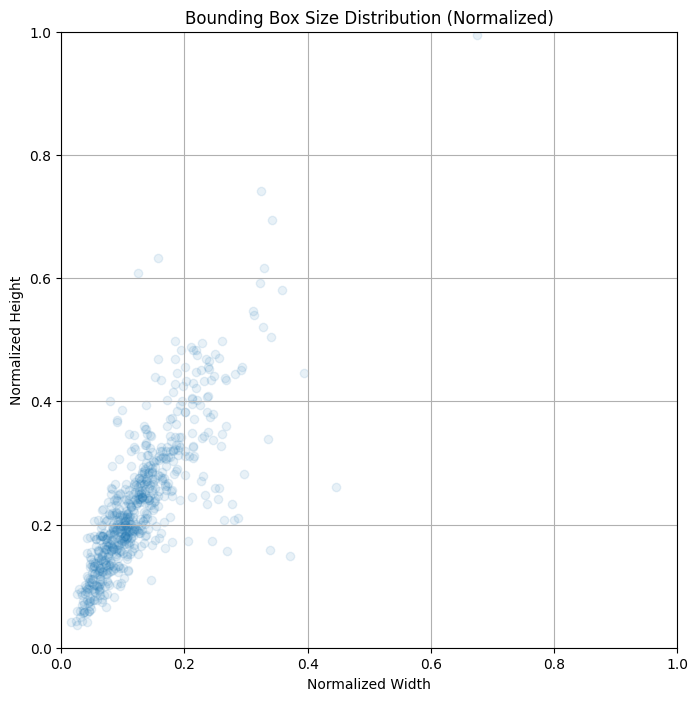

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

labels_path = os.path.join(dataset, 'train/labels/')
box_sizes = []

for filename in os.listdir(labels_path):
    with open(os.path.join(labels_path, filename), 'r') as f:
        for line in f:
            parts = line.split()
            width = float(parts[3])
            height = float(parts[4])
            box_sizes.append([width, height])

box_sizes = np.array(box_sizes)

plt.figure(figsize=(8, 8))
plt.scatter(box_sizes[:, 0], box_sizes[:, 1], alpha=0.1)
plt.title('Bounding Box Size Distribution (Normalized)')
plt.xlabel('Normalized Width')
plt.ylabel('Normalized Height')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Modelling

In [34]:
!yolo task=detect mode=train \
      model=yolo12s.pt \
      data={dataset}/data.yaml \
      epochs=100 \
      patience=20 \
      batch=32 \
      name='yolo12s_100epochs_20patience_dataset-asli'

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ffb/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12s_100epochs_20patience_dataset-asli, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

# Evaluation

In [35]:
YOLO_dir = f'{HOME}/runs/detect/yolo12s_100epochs_20patience_dataset-asli'

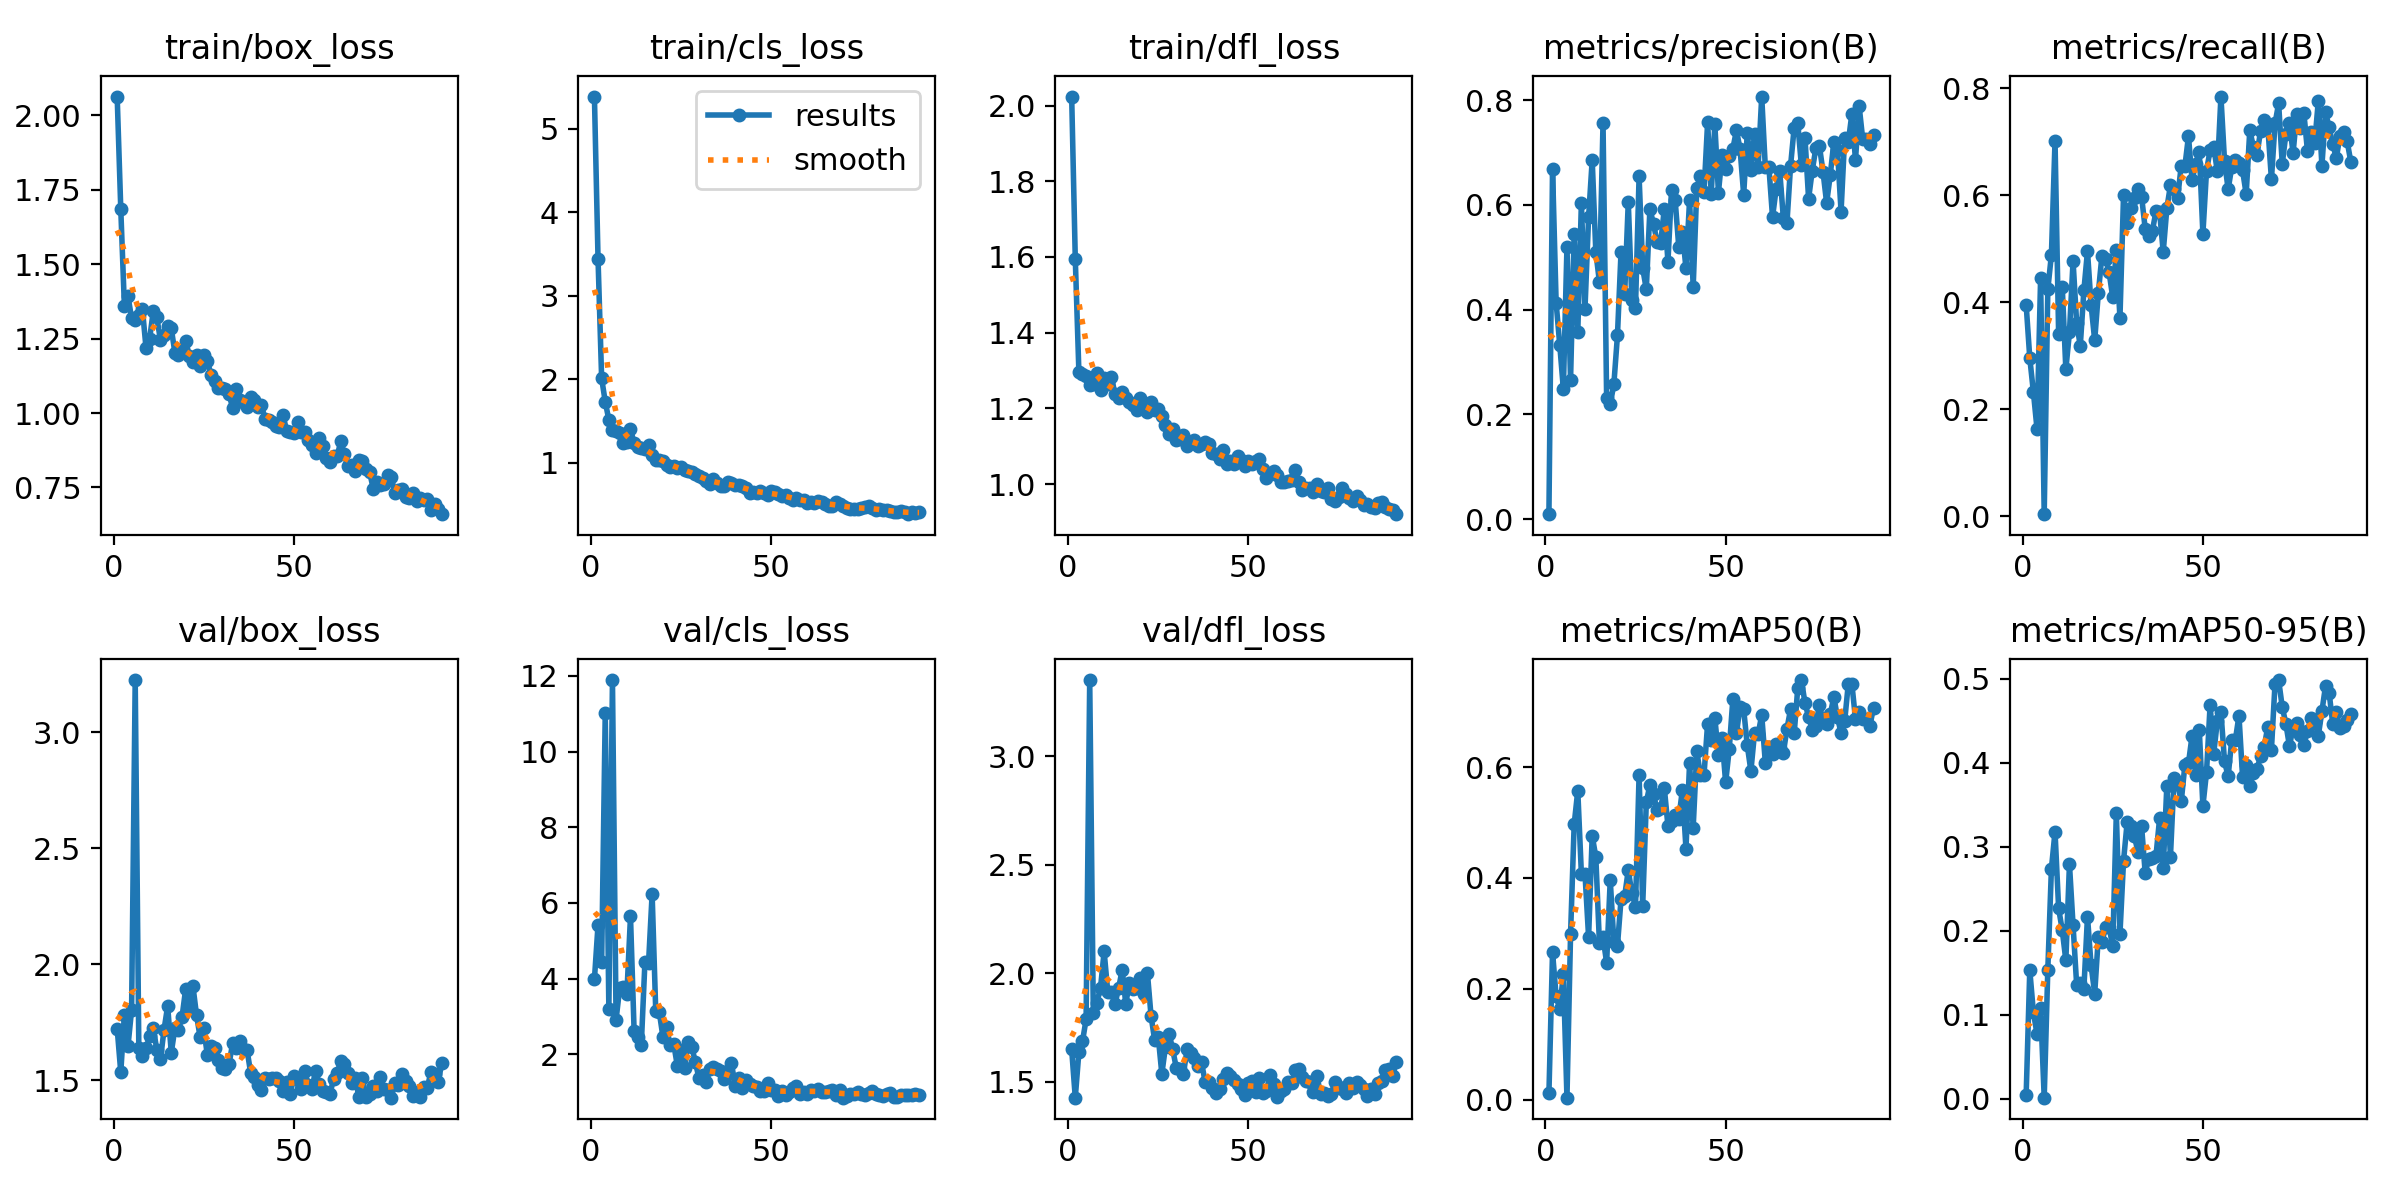

In [37]:
from IPython.display import display, Image
Image(filename=f'{YOLO_dir}/results.png')

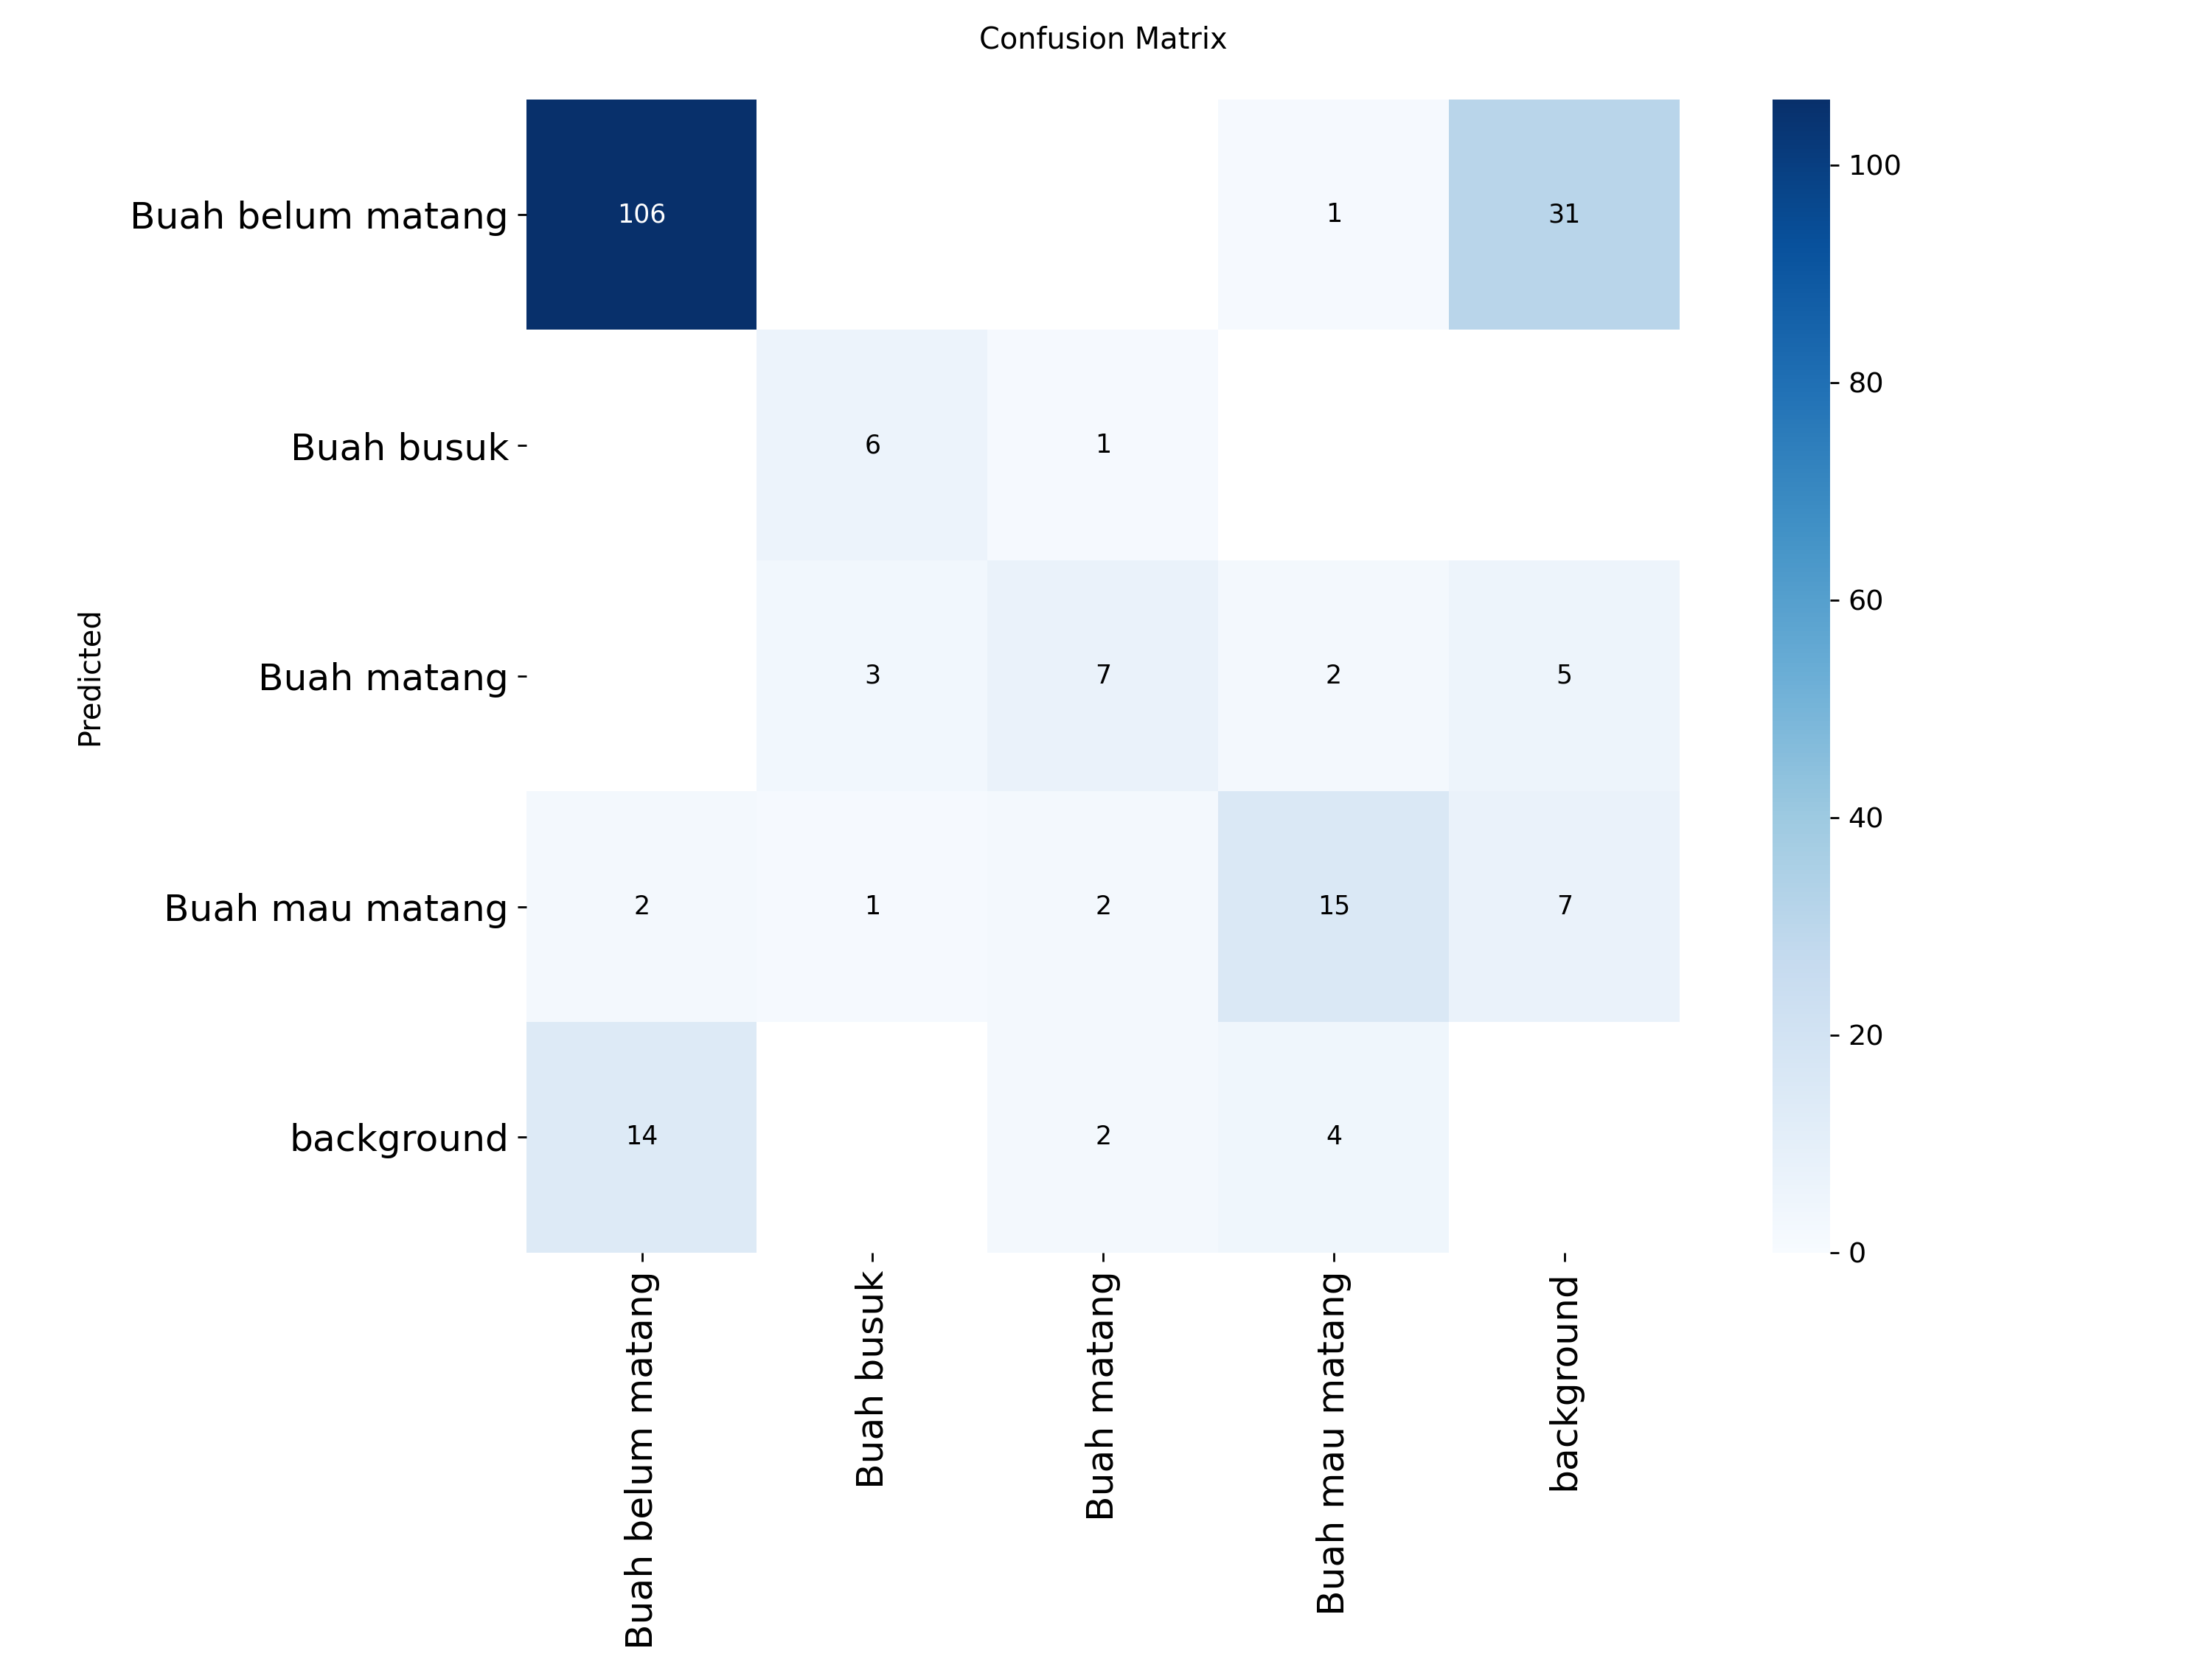

In [38]:
Image(filename=f'{YOLO_dir}/confusion_matrix.png')

In [40]:
!yolo task=detect mode=val \
    model={YOLO_dir}/weights/best.pt \
    data={dataset}/data.yaml \
    split=test

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1915.2±306.4 MB/s, size: 418.4 KB)
val: Scanning /kaggle/working/ffb/test/labels... 28 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 28/28 1.2Kit/s 0.0s
val: New cache created: /kaggle/working/ffb/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.8it/s 1.1s1.5s
                   all         28         69      0.731      0.683      0.729       0.46
     Buah belum matang         26         52      0.858      0.692      0.844      0.517
            Buah busuk          4          5      0.871        0.8      0.938      0.557
           Buah matang          3          3      0.358      0.667      0.356      0.273
       Buah mau matang          6          9      0.837      0.5

Confusion Matrix (Raw Count)


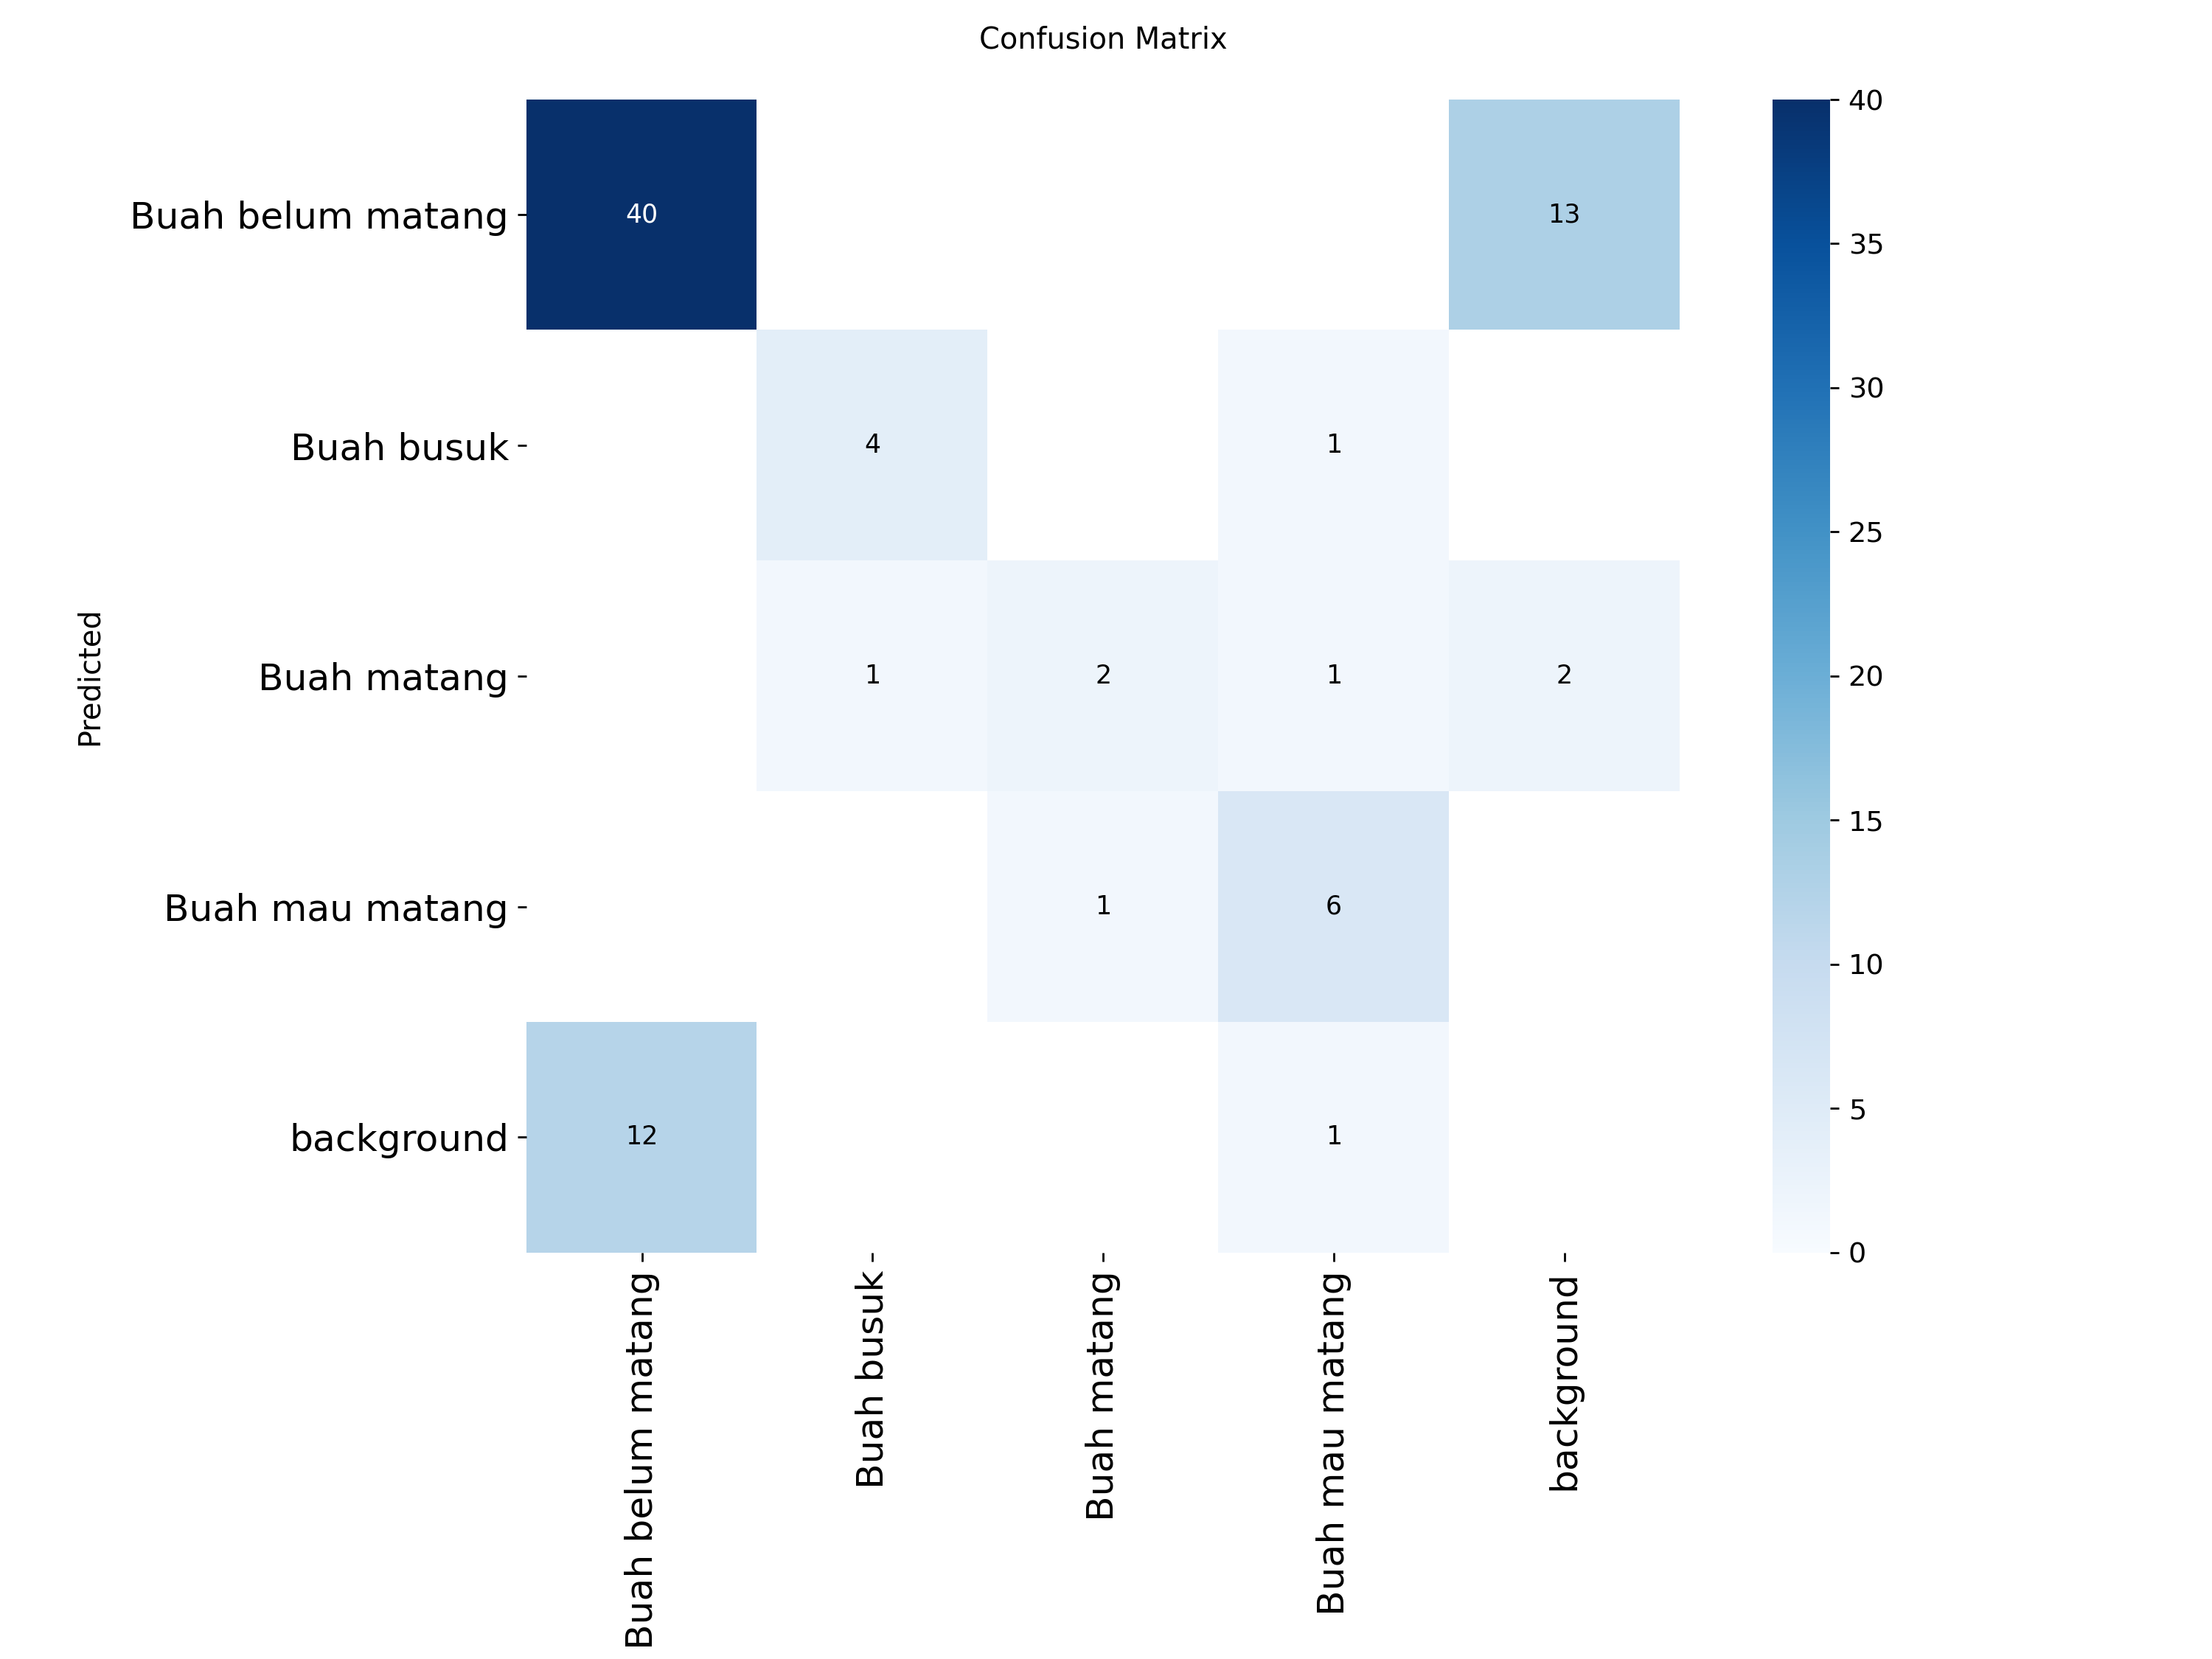


Confusion Matrix (Normalized)


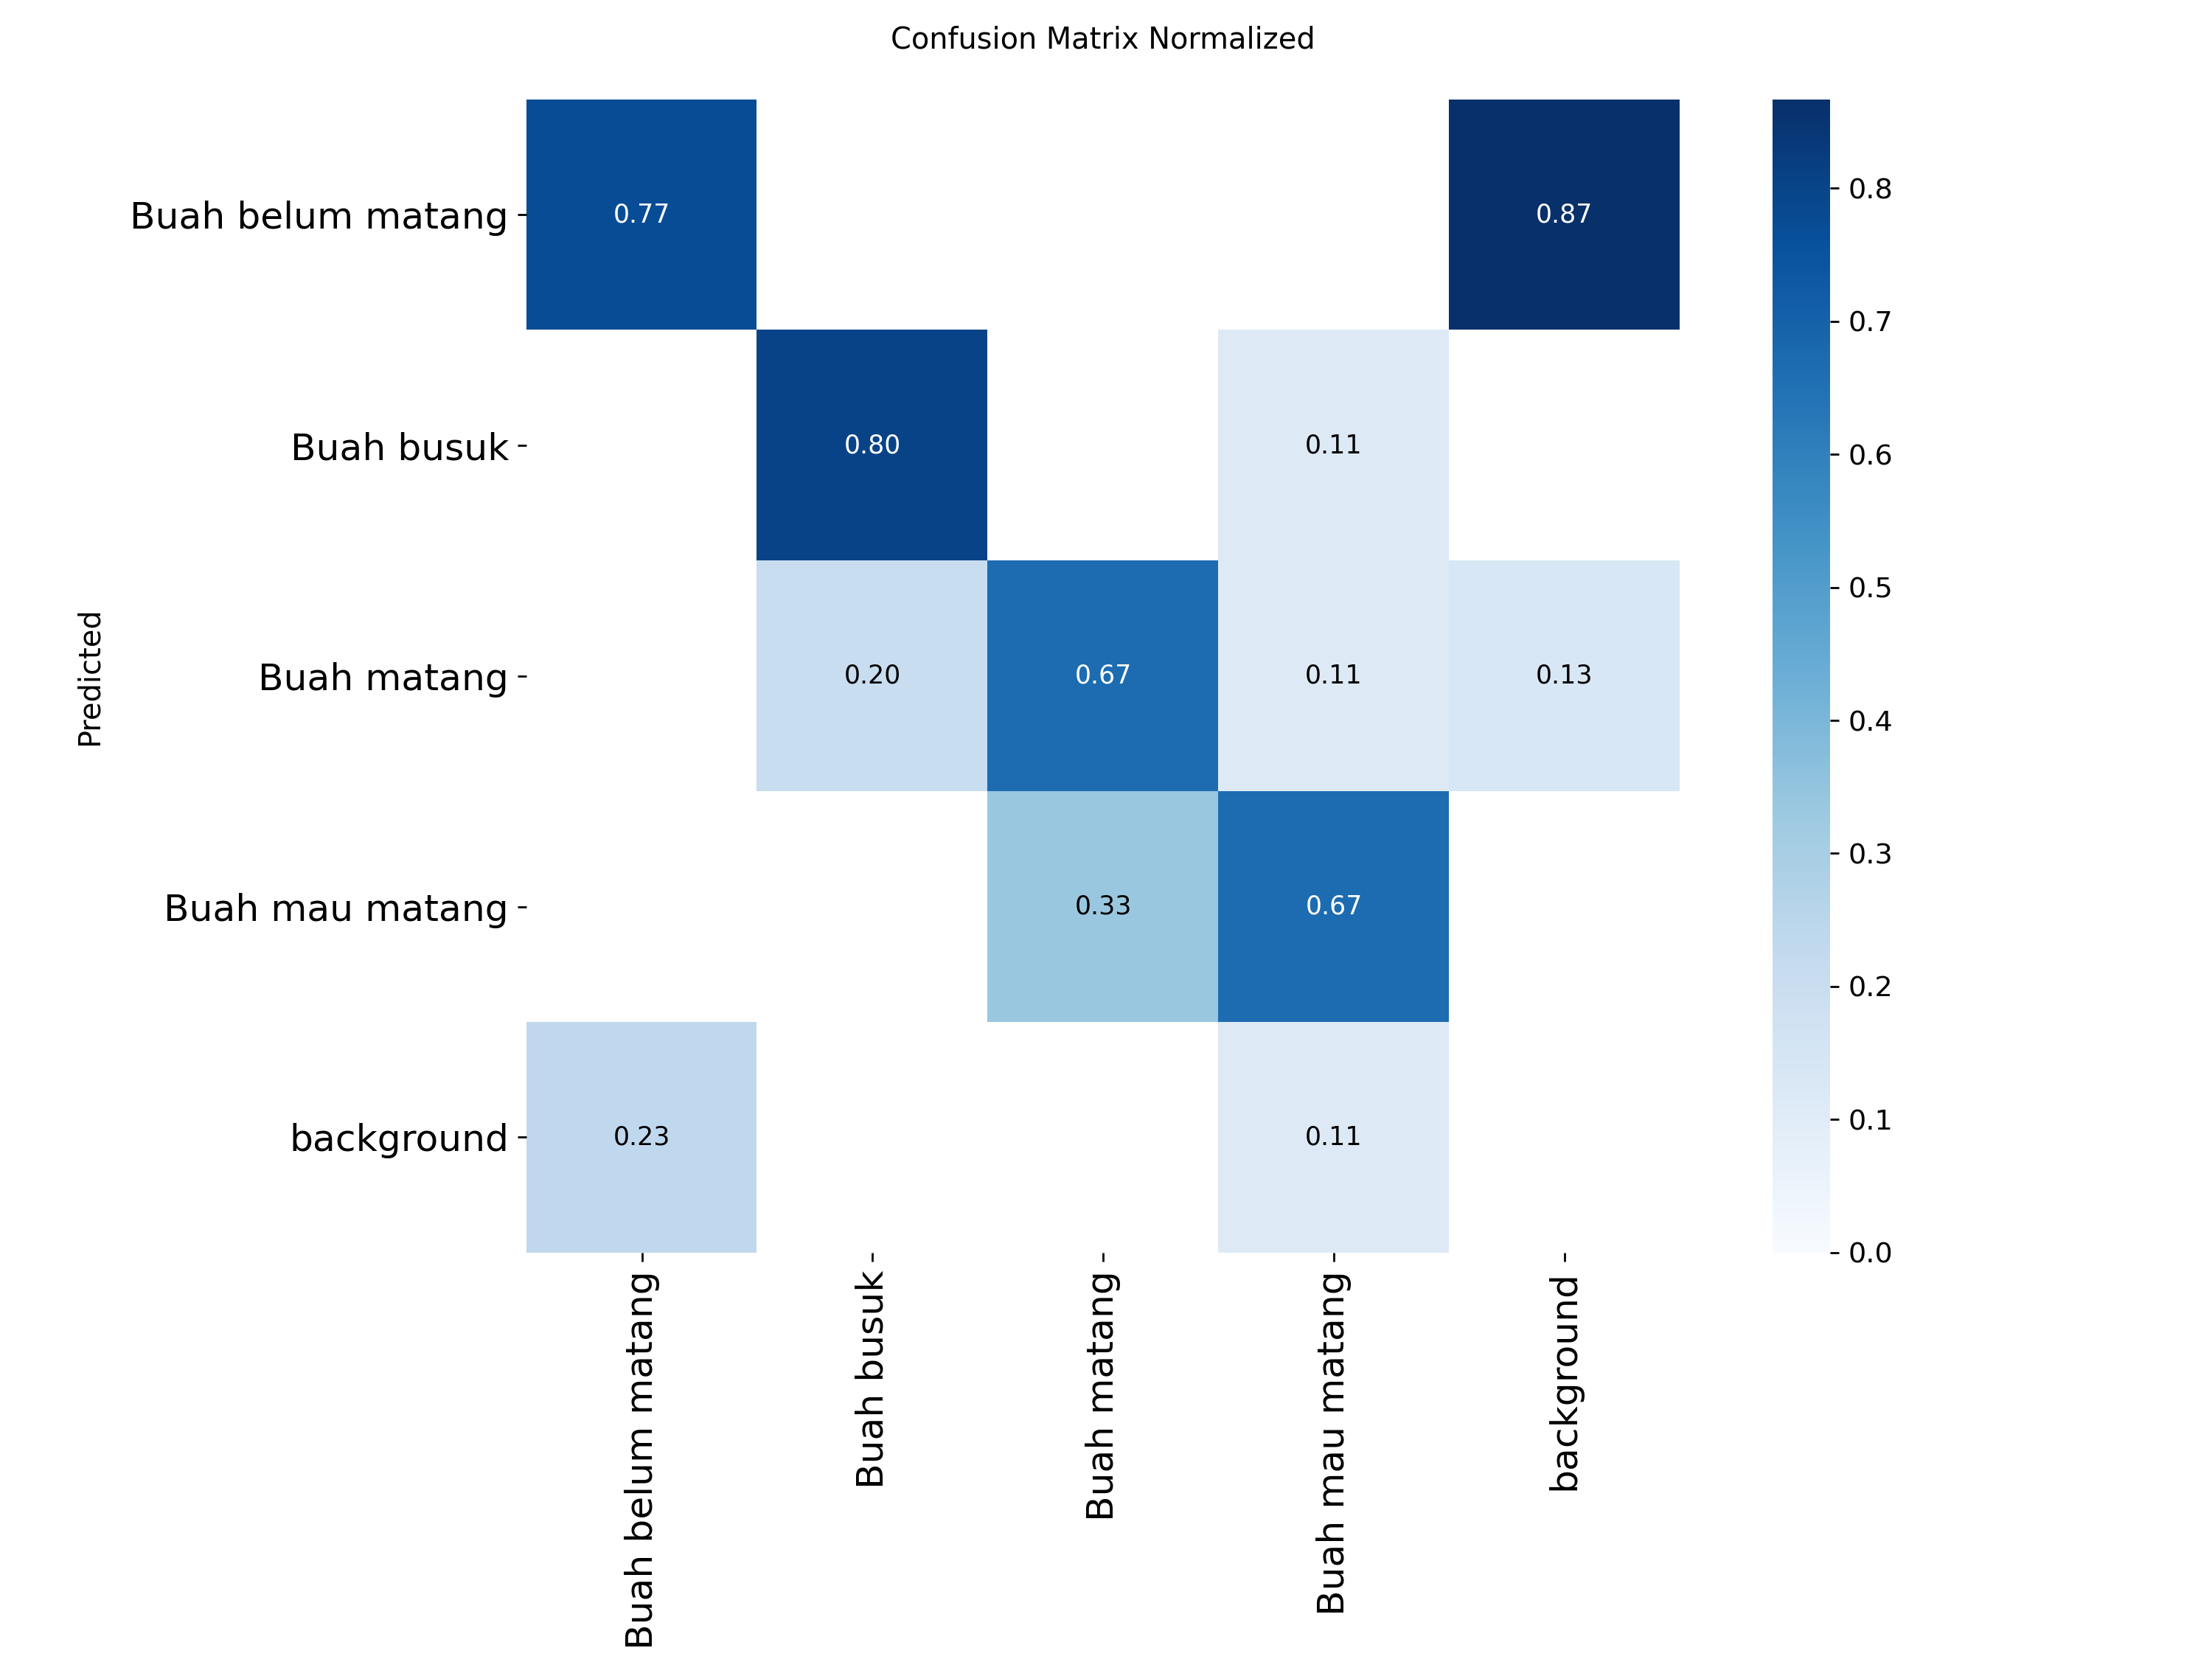

In [41]:
print("Confusion Matrix (Raw Count)")
display(Image(filename=f'{HOME}/runs/detect/val/confusion_matrix.png'))

print("\nConfusion Matrix (Normalized)")
display(Image(filename=f'{HOME}/runs/detect/val/confusion_matrix_normalized.png'))

Ground Truth Labels (from Test Set)


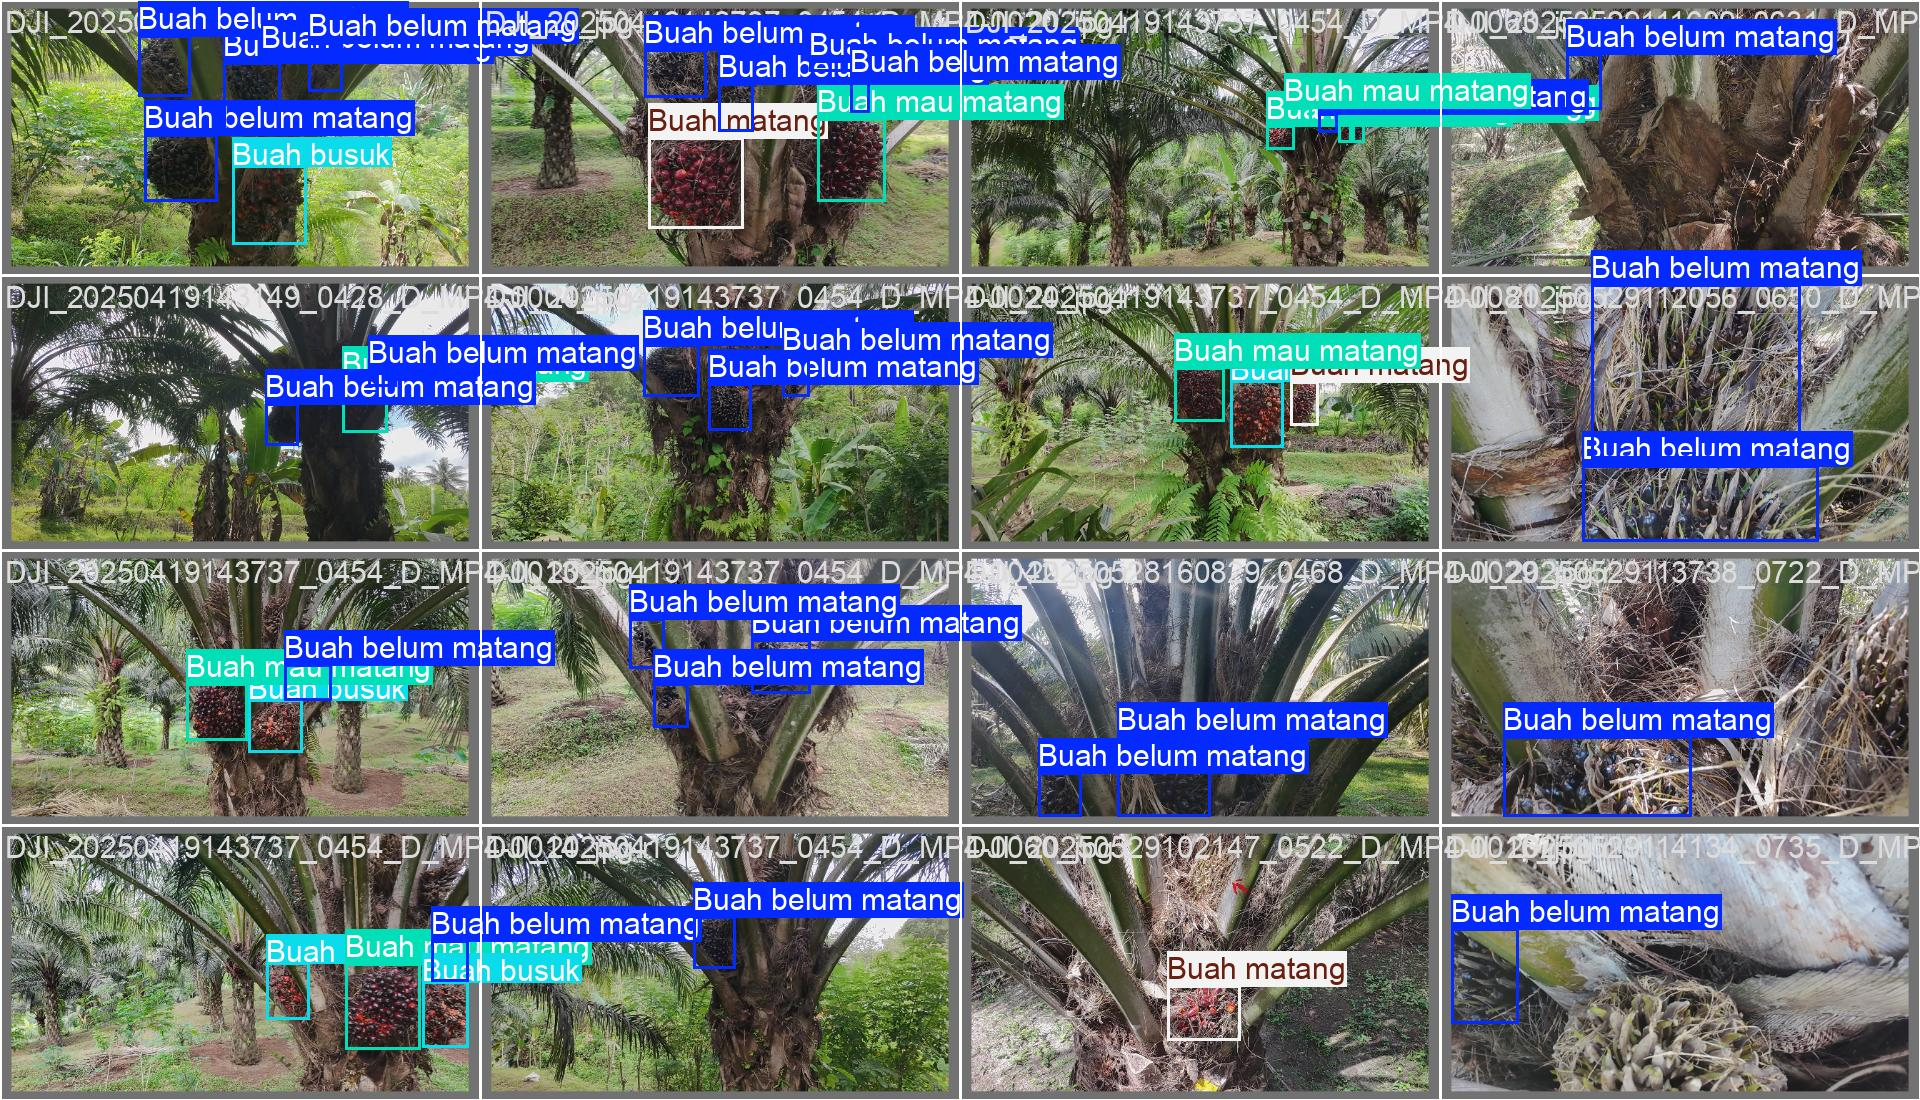


Model's Predictions


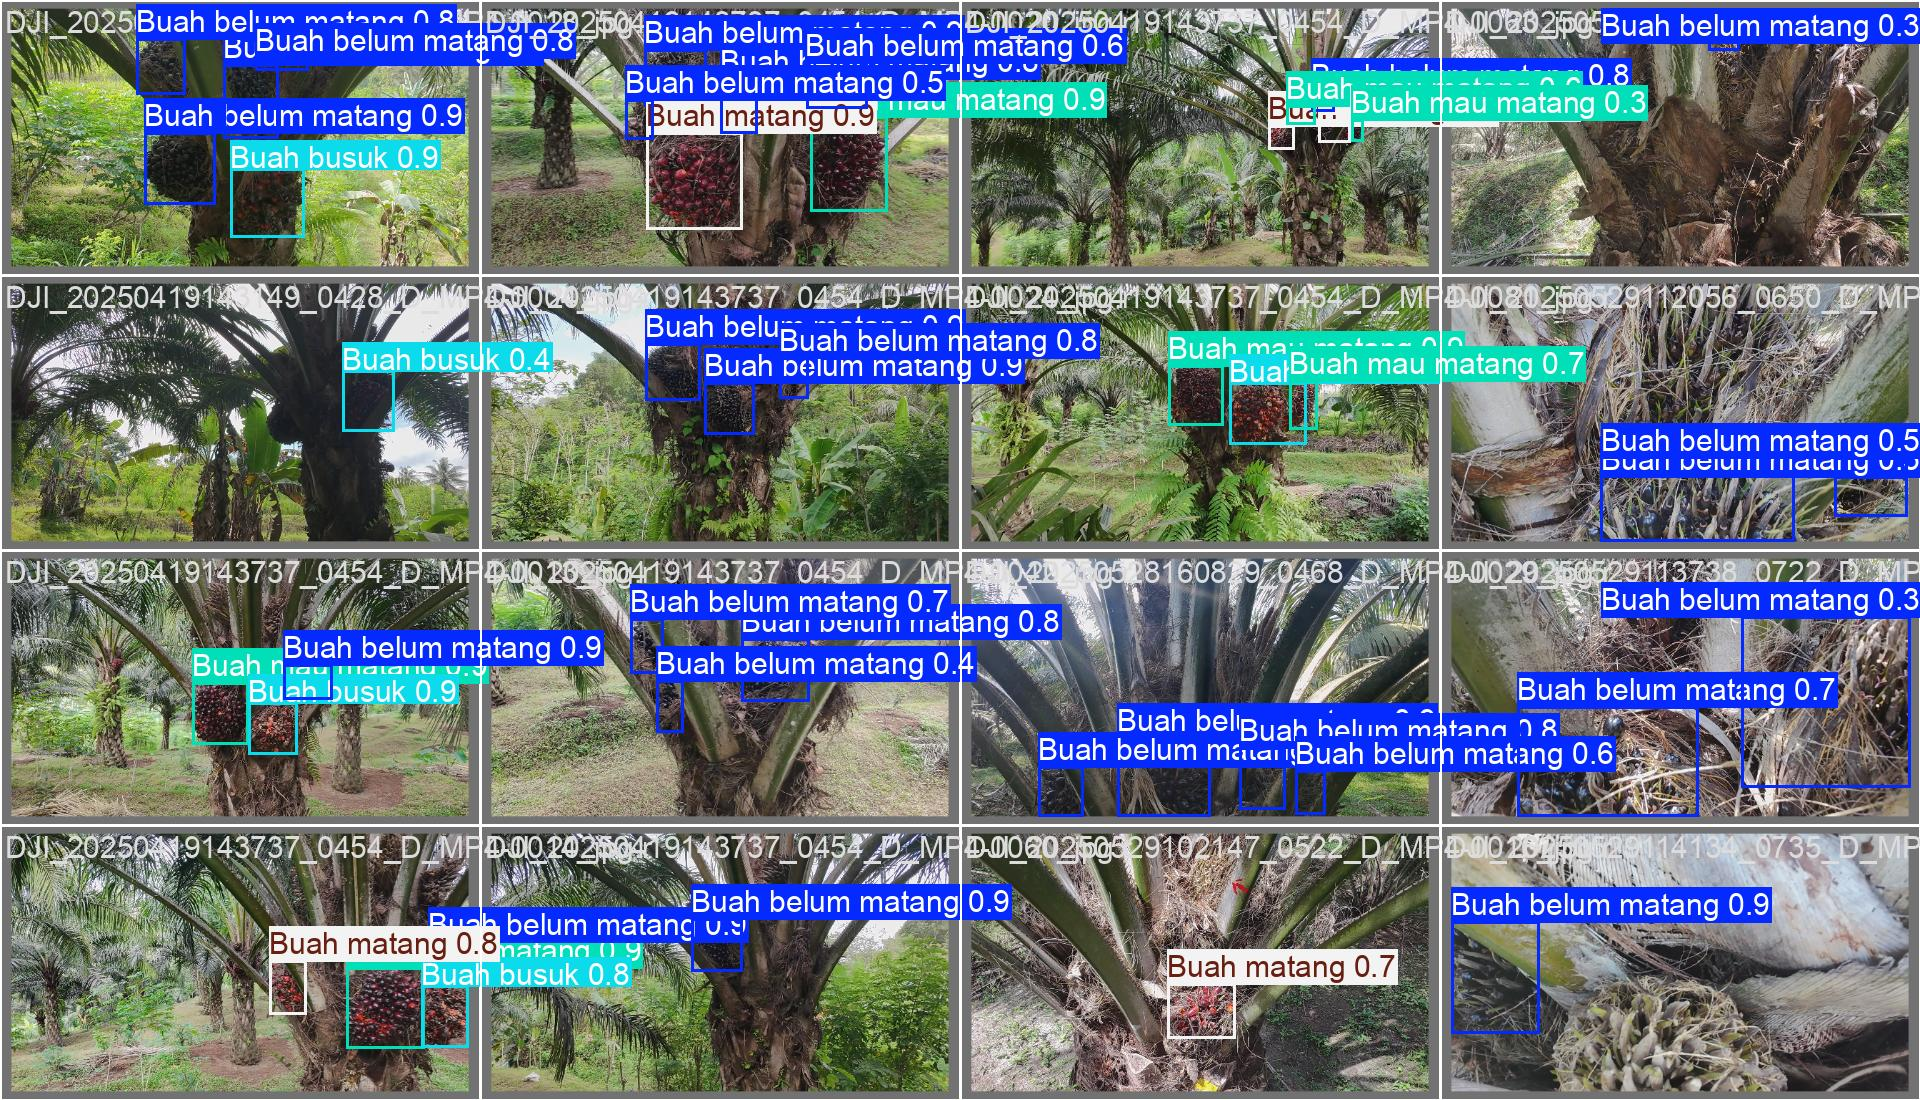

In [42]:
print("Ground Truth Labels (from Test Set)")
display(Image(filename=f'{HOME}/runs/detect/val/val_batch0_labels.jpg'))

print("\nModel's Predictions")
display(Image(filename=f'{HOME}/runs/detect/val/val_batch0_pred.jpg'))

In [43]:
!gdown 'https://drive.google.com/uc?export=download&id=1rjJhPpmDJXxJ-X3zV2V4lPz5Bx1Ewbo6' -O {HOME}/drone_record_inference_test.mp4

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1rjJhPpmDJXxJ-X3zV2V4lPz5Bx1Ewbo6
From (redirected): https://drive.google.com/uc?export=download&id=1rjJhPpmDJXxJ-X3zV2V4lPz5Bx1Ewbo6&confirm=t&uuid=dfe78c55-a8a1-445b-97ba-3bd44e192a9f
To: /kaggle/working/drone_record_inference_test.mp4
100%|████████████████████████████████████████| 817M/817M [00:08<00:00, 93.0MB/s]


In [ ]:
!yolo task=detect mode=predict \
    model={YOLO_dir}/weights/best.pt \
    conf=0.25 \
    source={HOME}/drone_record_inference_test.mp4 \
    verbose=False \
    save=True

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs
